In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def reset_timestamp(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def find_clumsy_directories(root='.'):
    res = []
    for dirpath, dirnames, filenames in os.walk(root):
        for dirname in dirnames:
            if 'clumsy' in dirname.lower() or 'validation' in dirname.lower():
                res.append(os.path.join(dirpath, dirname))
    return res

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = reset_timestamp(df)
    df = calculate_power(df)
    df.to_csv(f'.\\{data_path.strip(".log")}.csv', index=False)
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    if len(file_path.split('\\')[1].split('-')) == 3:
        altered_bandwidth = file_path.split('\\')[1].split('-')[1] == 'bandwidth'
        altered_dropchance = file_path.split('\\')[1].split('-')[1] == 'dropchance'
        bandwidth = int(file_path.split('\\')[1].split('-')[2][:-4]) if file_path.split('\\')[1].split('-')[1] == 'bandwidth' else 999999
        dropchance = float(file_path.split('\\')[1].split('-')[2]) if file_path.split('\\')[1].split('-')[1] == 'dropchance' else 0
    else:
        altered_bandwidth = True
        altered_dropchance = True
        bandwidth = 999999
        dropchance = 0
    device = file_path.split('\\')[2]
    app = file_path.split('\\')[3].strip('-W')
    app_details = file_path.split('\\')[4]
    is_record = 'record' in file_path.split('\\')[5]
    is_wireless = '-W' in file_path.split('\\')[3]
    repetition = file_path.split('\\')[5].strip('record') if 'record' in file_path.split('\\')[5] else file_path.split('\\')[5].strip('replay')
    
#     print(df)
    return [altered_bandwidth, altered_dropchance, bandwidth, dropchance, device, app, app_details, is_record, is_wireless, repetition]


clumsy_dirs = find_clumsy_directories()

df_aggregated = []  # List to store dictionaries for each row

for clumsy in clumsy_dirs:
    for root, dirs, files in os.walk(clumsy, topdown=False):
        for name in files:
            if name == 'battery_manager.log':
                if os.path.join(root, name) == '.\\clumsy-dropchance-0.05\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replay1.2\\battery_manager.log':
                    continue
                try:
                    print(os.path.join(root, name))
                    energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                    row_data = create_dataframe(os.path.join(root, name)) + [energy, length, float(energy / length)]
                    # Append a dictionary for each row
                    df_aggregated.append(dict(zip(['altered_bandwidth', 'altered_dropchance', 'bandwidth', 'dropchance', 'device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)', 'Energy per Second (J/s)'], row_data)))
                except:
                    print(f'{os.path.join(root, name)} not functional')

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(df_aggregated)
df

.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log


,altered_bandwidth,altered_dropchance,bandwidth,dropchance,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,True,False,1,1617.171011,257.057,6.291099
1,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,False,False,1.0,1697.401878,265.220,6.399977
2,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,False,False,1.1,1695.442951,265.989,6.374109
3,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,False,False,1.2,1716.645147,265.949,6.454791
4,True,False,100,0.0,Quest-Pro,BeatSaber,PopStars-Medium,True,False,1,2132.318163,283.780,7.513983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,True,False,1,2132.318163,283.780,7.513983
104,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,True,False,2,1974.740548,265.396,7.440732
105,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,0.0,1958.622026,278.179,7.040869
106,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,1.0,1962.671679,273.969,7.163846


In [14]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                 "xtick.bottom": True,
                 "ytick.left": True,
                 "axes.edgecolor": "black",
                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray"}

# sns.set_theme(style="whitegrid", rc=custom_params)
# sns.set_palette("deep")
# sns.set(font_scale=1.7)

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

custom_outliers = {'marker': 'o', 
                   'markerfacecolor': 'grey'}

C:\Users\radua\AppData\Local\Temp\ipykernel_18796\3888802680.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y='device', x='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, palette='deep', flierprops=custom_outliers)


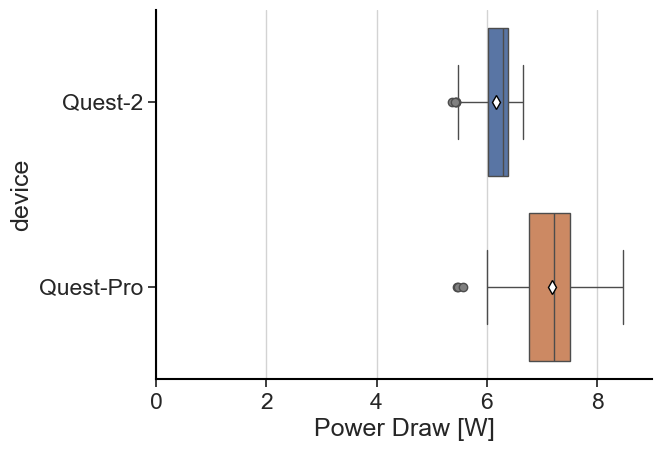

In [15]:
# print(df.empty())
# pd.set_option('Energy per Second (J/s).max_rows', None)

# Print the entire 'device' column
# print(df['Energy per Second (J/s)'])
# print(df.dropna())
# df['device'] = df['device'].astype(str)
sns.boxplot(data=df, y='device', x='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, palette='deep', flierprops=custom_outliers)
plt.xlim(0, 9)
plt.xlabel('Power Draw [W]')
plt.show()

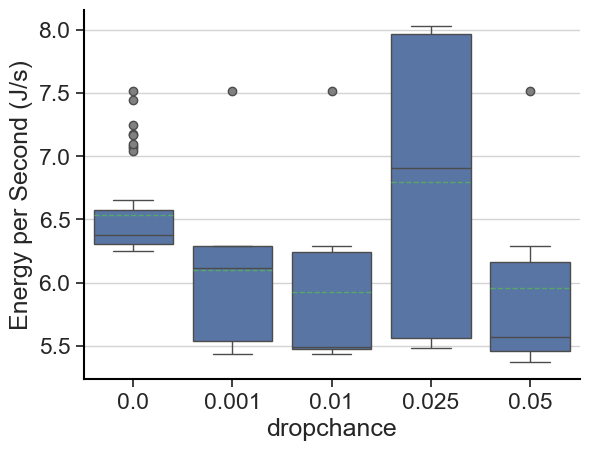

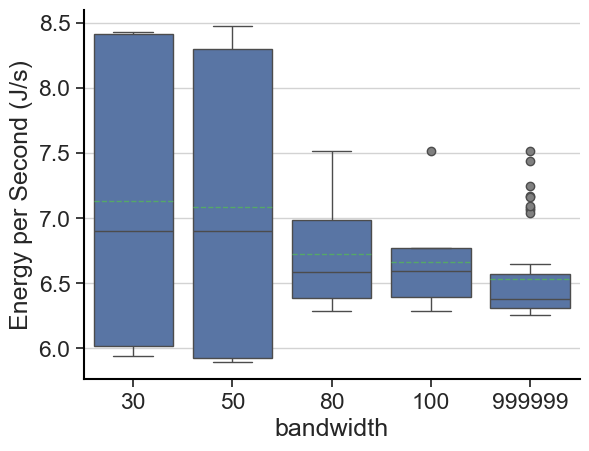

In [16]:
sns.boxplot(data=df[(df.altered_dropchance == True)], x='dropchance', y='Energy per Second (J/s)', showmeans=True, meanline=True, flierprops=custom_outliers)
plt.show()

sns.boxplot(data=df[(df.altered_bandwidth == True)], x='bandwidth', y='Energy per Second (J/s)', showmeans=True, meanline=True, flierprops=custom_outliers)
plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_18796\208648587.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=ax, flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_18796\208648587.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


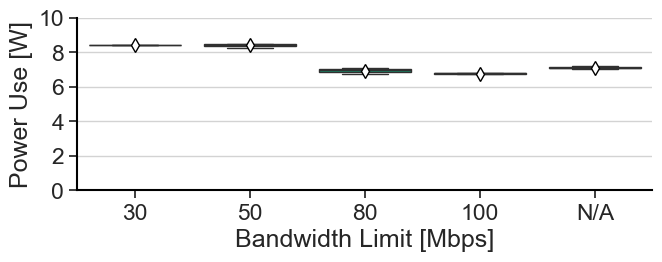

In [17]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.6)

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=ax, flierprops=custom_outliers)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[4] = 'N/A'
ax.set_xticklabels(labels)
ax.set_ylim(0, 9)
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_xlabel('Bandwidth Limit [Mbps]')
ax.set_ylabel('Power Use [W]')

plt.tight_layout()
# plt.savefig('./figures/first_pager_bandwidth.pdf', bbox_inches='tight', format='pdf')
plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_18796\1438517102.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: '400' if x == 999999 else str(x))
C:\Users\radua\AppData\Local\Temp\ipykernel_18796\1438517102.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot.sort_values('bandwidth', ascending=False, inplace=True)
C:\Users\radua\AppData\Local\Temp\ipykernel_18796\1438517102.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `

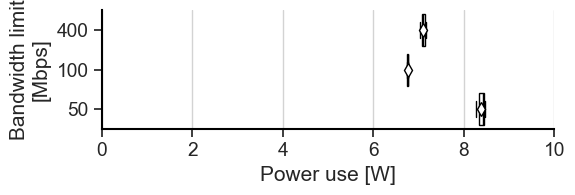

Mean power increase from 0 to 999999 Mbps: 1.28 W


In [34]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

fig, ax = plt.subplots(figsize=(6, 2.2))
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.25)

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro') & (df['bandwidth'] != 30) & (df['bandwidth'] != 80)]
to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: '400' if x == 999999 else str(x))
to_plot.sort_values('bandwidth', ascending=False, inplace=True)

sns.boxplot(x=to_plot['Energy per Second (J/s)'], y=to_plot['bw_text'], showmeans=True, meanprops=custom_mean, palette=["white"], ax=ax, flierprops=custom_outliers, **PROPS)

ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_ylabel('Bandwidth limit\n[Mbps]')
ax.set_xlabel('Power use [W]')

plt.tight_layout()
plt.savefig('./figures/first_pager_bandwidth.pdf', bbox_inches='tight', format='pdf')
plt.show()

mean_power_increase = to_plot[to_plot['bandwidth'] == 50]['Energy per Second (J/s)'].mean() - to_plot[to_plot['bandwidth'] == 999999]['Energy per Second (J/s)'].mean()
print(f'Mean power increase from 0 to 999999 Mbps: {mean_power_increase:.2f} W')

C:\Users\radua\AppData\Local\Temp\ipykernel_18796\2743508383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: '400' if x == 999999 else str(x))
C:\Users\radua\AppData\Local\Temp\ipykernel_18796\2743508383.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot.sort_values('bandwidth', ascending=False, inplace=True)
C:\Users\radua\AppData\Local\Temp\ipykernel_18796\2743508383.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y`

Quest Pro, 30Mbps 8.418469977543731
Quest Pro, 50Mbps 8.384464237846688
Quest Pro, 80Mbps 6.929555626518019
Quest Pro, 100Mbps 6.760218183397259
Quest Pro, 999999Mbps 7.103325110079296


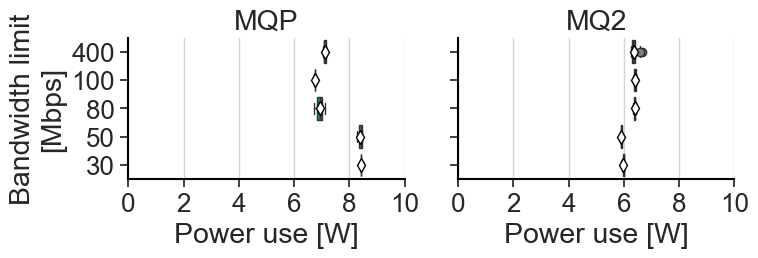

Quest 2, 30Mbps 5.989859436460505
Quest 2, 50Mbps 5.913100153258785
Quest 2, 80Mbps 6.392722708751935
Quest 2, 100Mbps 6.409625648566487
Quest 2, 999999Mbps 6.372548478352092


In [37]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=2, sharey=True)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

# to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]
to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: '400' if x == 999999 else str(x))
to_plot.sort_values('bandwidth', ascending=False, inplace=True)

sns.boxplot(x=to_plot['Energy per Second (J/s)'], y=to_plot['bw_text'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=ax[0], flierprops=custom_outliers)

ax[0].set_xticks([0, 2, 4, 6, 8, 10])
ax[0].set_ylabel('Bandwidth limit\n[Mbps]')
ax[0].set_xlabel('Power use [W]')
ax[0].set_title('MQP')

print('Quest Pro, 30Mbps', to_plot[to_plot['bandwidth'] == 30]['Energy per Second (J/s)'].mean())
print('Quest Pro, 50Mbps', to_plot[to_plot['bandwidth'] == 50]['Energy per Second (J/s)'].mean())
print('Quest Pro, 80Mbps', to_plot[to_plot['bandwidth'] == 80]['Energy per Second (J/s)'].mean())
print('Quest Pro, 100Mbps', to_plot[to_plot['bandwidth'] == 100]['Energy per Second (J/s)'].mean())
print('Quest Pro, 999999Mbps', to_plot[to_plot['bandwidth'] == 999999]['Energy per Second (J/s)'].mean())



to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-2')]
to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: '400' if x == 999999 else str(x))
to_plot.sort_values('bandwidth', ascending=False, inplace=True)

sns.boxplot(x=to_plot['Energy per Second (J/s)'], y=to_plot['bw_text'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=ax[1], flierprops=custom_outliers)

ax[1].set_xticks([0, 2, 4, 6, 8, 10])
ax[1].set_ylabel('Bandwidth limit\n[Mbps]')
ax[1].set_xlabel('Power use [W]')
ax[1].set_title('MQ2')

plt.tight_layout()
plt.savefig('./figures/energy/watts_vs_bandwidth.pdf', dpi=300, format='pdf')
plt.show()


print('Quest 2, 30Mbps', to_plot[to_plot['bandwidth'] == 30]['Energy per Second (J/s)'].mean())
print('Quest 2, 50Mbps', to_plot[to_plot['bandwidth'] == 50]['Energy per Second (J/s)'].mean())
print('Quest 2, 80Mbps', to_plot[to_plot['bandwidth'] == 80]['Energy per Second (J/s)'].mean())
print('Quest 2, 100Mbps', to_plot[to_plot['bandwidth'] == 100]['Energy per Second (J/s)'].mean())
print('Quest 2, 999999Mbps', to_plot[to_plot['bandwidth'] == 999999]['Energy per Second (J/s)'].mean())


C:\Users\radua\AppData\Local\Temp\ipykernel_18796\3690304840.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[0], flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_18796\3690304840.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels)
C:\Users\radua\AppData\Local\Temp\ipykernel_18796\3690304840.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['dropchance'], showmeans=True, mean

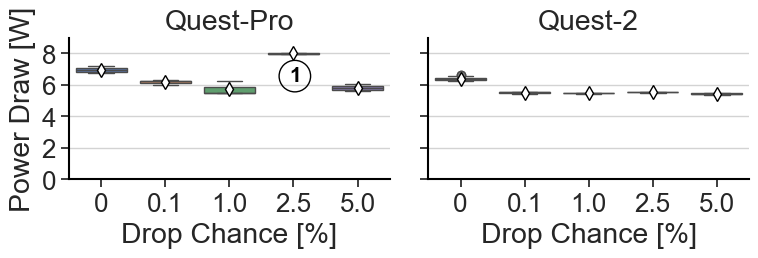

In [11]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=2, sharey=True)

to_plot = df[(df['altered_dropchance'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=axes[0], flierprops=custom_outliers)
axes[0].annotate('1', (2.93, 6.2), 
                 bbox={"boxstyle" : "circle", "facecolor" : "none", "edgecolor" : "black"}, 
                 color='black', fontweight='bold', fontsize=15)

labels = [float(item.get_text()) for item in axes[0].get_xticklabels()]
labels = [str(x*100) for x in labels]
labels[0] = '0'
axes[0].set_xticklabels(labels)
axes[0].set_ylim(0, 9)
axes[0].set_yticks([0, 2, 4, 6, 8])
axes[0].set_xlabel('Drop Chance [%]')
axes[0].set_ylabel('Power Draw [W]')
axes[0].set_title('MQP')

to_plot = df[(df['altered_dropchance'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-2')]

sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=axes[1], flierprops=custom_outliers)

labels = [float(item.get_text()) for item in axes[1].get_xticklabels()]
labels = [str(x*100) for x in labels]
labels[0] = '0'
axes[1].set_xticklabels(labels)
axes[1].set_ylim(0, 9)
axes[1].set_xlabel('Drop Chance [%]')
axes[1].set_ylabel('Power Draw [W]')
axes[1].set_title('MQ2')

plt.tight_layout()
plt.savefig('./figures/energy/watts_vs_dropchance.pdf', dpi=300, format='pdf')
plt.show()